
# Week 1 Practical

##### version 1.0

###### The INFS7410 Teaching Team

---

Welcome to INFS7410! 

The content of this course includes hands-on activities to better understand information retrieval methods and technology. The practical classes aim to introduce you to concepts in a hands-on manner, while the online lectures aim to introduce these concepts with the underlying theories, and the live Q/A lecture session aims to discuss questions and exercises about the week's lecture content. 

The prac will run online as a computer lab, where learning will happen by doing, rather than listening.

**You will need to program in this course.** Please keep in mind that we assume you know how to program, and that you have familiarity with programming languages like Python. In particular, most of the code we will show you in this course is in **Python**, and the scaffolding we will provide you for the project assignments is in Python. *If this course is your first shot at developing a software project, then you may want to reconsider whether you will have a fair go at successfully completing the learning activities the course will offer.* 
Note, you may be a proficient programmer and software engineer, but not know Python. This is generally fine: you should be able to rapidly pick up a new language. 

In addition, we use Jupyter notebooks for the pracs and assignments; if you never used notebooks before, don't worry, it is easy, and you can check out this [tutorial](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) before you start this exercise.

Note: Whenever you see `# TODO` in a cell, then it is an exercise you need to code.

**You will need to use the command-line in this course.** Along with being able to program, we expect you know how to interact with the command line tool, for example to operate on the file system, to script simple routines and so on. 


As a side note: we also expect you understand *Maths* and are confident writing and deriving equations, along with translating equation into algorithms and code. Maths will mostly appear during the lectures, but the pracs will also include Maths expressions when relevant. 


##### About today's prac
In this prac you will learn about text analysis and indexing. Specifically, you will learn how to use Pyserini to index a collection of data (this will be the same collection we will use throughout many of the pracs, and in the assignments) and the Zipf's Law. There are two exercises to complete.

The first exercise will have you exploring indexing with Pyserini. You will convert the raw collection into JSON, and then use Pyserini commands to create an index of the collection. Then, you will learn how to use the Pyserini index APIs to access the statistics of the index.

The second exercise explores the Zipf's Law. The Zipf's Law expresses an empirical relationship between the frequencies of words in a text collection, and the rank of each term if terms were ordered by decreasing frequency. Rather than re-telling you the law, we want to have you derive the empirical relation.

##### Prac Etiquette
This prac runs over Zoom. Please refrain from irrelevant conversations during prac activities. Be respectful of everyone's opinions and ideas during the prac activities. You will be asked to leave if you disturb. Remember the tutor is there to help you understand and learn, not to provide debugging of your code or solutions to assignments. 

---

# Exercise 1: Indexing the collection

Lets first get some ideas of what our collection looks like. The code below will print out the first 10 lines in our raw collection.
(Note, to run the snippet of code below may take up to 1 minute, as it will load the whole file in memory first)

In [4]:
with open ('collection.tsv', 'r') as f:
     lines = f.readlines()
    for i in range(10):
         print(lines[i])


0	The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.

1	The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.

2	Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.

3	The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refers specifically to the period of the project from 194 â¦ 2-1946 under the control of the U.S. Army Corps of Engine

A faster (but less elegant) code snippet to generate the output above would be:

```
with open ('collection.tsv', 'r') as f:   
    i = 0
    for line in f:
        print(line)
        i+=1
        if i == 10:
            break
```

As you can see, each line in the `collection.tsv` has two columns, seperated by `'\t'`. The first column is an integer indicating the document id. The second column is the raw text. Each document in this collection is actually a short passage crawled from the Internet by the Bing search engine. 

In [4]:
# Practice, find out the collection size, i.e., how many documents in the collection.
# TODO
import csv

with open('collection.tsv','r') as f:
    reader = csv.reader(f, delimiter='\t')
    last = f.readlines()[-1].split()
    print(last[0])



8841822


Indexing the collection with Pyserini requires the collection to be json format. So let's convert the raw collection into json format first. We provide a python script in `tools/` to do that. The script should generate 9 json files in `collections/collection_jsonl`

In [3]:
!python tools/convert_collection_to_jsonl.py \
 --collection-path collection.tsv \
 --output-folder collection/collection_jsonl

Converting collection...
Converted 0 docs, writing into file 1
Converted 100,000 docs, writing into file 1
Converted 200,000 docs, writing into file 1
Converted 300,000 docs, writing into file 1
Converted 400,000 docs, writing into file 1
Converted 500,000 docs, writing into file 1
Converted 600,000 docs, writing into file 1
Converted 700,000 docs, writing into file 1
Converted 800,000 docs, writing into file 1
Converted 900,000 docs, writing into file 1
Converted 1,000,000 docs, writing into file 2
Converted 1,100,000 docs, writing into file 2
Converted 1,200,000 docs, writing into file 2
Converted 1,300,000 docs, writing into file 2
Converted 1,400,000 docs, writing into file 2
Converted 1,500,000 docs, writing into file 2
Converted 1,600,000 docs, writing into file 2
Converted 1,700,000 docs, writing into file 2
Converted 1,800,000 docs, writing into file 2
Converted 1,900,000 docs, writing into file 2
Converted 2,000,000 docs, writing into file 3
Converted 2,100,000 docs, writing i

Before starting indexing, we should allocate enough memory for the Java virtual machine heap (expresed in MB).
Note, if you get an error in execurting the code below, then:

1. close this notebook and go back to command line
2. close the jupyter instance, and exit the conda environment (`conda deactivate`) and open a new terminal session
3. then reactivate the infs7410 environment (`source activate infs7410`)
4. then re-execute `jupyter notebook` and reload this notebook from the interface
5. re-execute the code block below

In [5]:
import jnius_config
jnius_config.add_options('-Xms128m', '-Xmx8192m') # assign a maximum memory of 8192mb (~8GB) to the java jvm



The code below will use Pyserini to index the json collection and store the index into `indexes/` with name `lucene-index-msmarco-passage-noProcessing`. You may already realize from the parameters that it will keep stopwords and won't use any stemmer. The indexing speed may vary; on a modern desktop with an SSD, indexing takes a few minutes. (so hold on tight, as you will see no output until the collection is loaded by the indexer; then you will still have to wait, until the index is created)

In [6]:
!python -m pyserini.index -collection JsonCollection -generator DefaultLuceneDocumentGenerator \
 -threads 9 -input collection/collection_jsonl \
 -index indexes/lucene-index-msmarco-passage-noProcessing \
 -optimize \
 -storeRaw \
 -stemmer none \
 -keepStopwords

2021-08-16 12:24:29,422 INFO  [main] index.IndexCollection (IndexCollection.java:643) - Setting log level to INFO
2021-08-16 12:24:29,424 INFO  [main] index.IndexCollection (IndexCollection.java:646) - Starting indexer...
2021-08-16 12:24:29,424 INFO  [main] index.IndexCollection (IndexCollection.java:647) - ============ Loading Parameters ============
2021-08-16 12:24:29,425 INFO  [main] index.IndexCollection (IndexCollection.java:648) - DocumentCollection path: collection/collection_jsonl
2021-08-16 12:24:29,425 INFO  [main] index.IndexCollection (IndexCollection.java:649) - CollectionClass: JsonCollection
2021-08-16 12:24:29,425 INFO  [main] index.IndexCollection (IndexCollection.java:650) - Generator: DefaultLuceneDocumentGenerator
2021-08-16 12:24:29,425 INFO  [main] index.IndexCollection (IndexCollection.java:651) - Threads: 9
2021-08-16 12:24:29,426 INFO  [main] index.IndexCollection (IndexCollection.java:652) - Stemmer: none
2021-08-16 12:24:29,426 INFO  [main] index.IndexColle

Now that the index has been created, let's get some index statistics

In [7]:
from pyserini.index import IndexReader

# Initialize from an index path:
index_reader = IndexReader('indexes/lucene-index-msmarco-passage-noProcessing/')
print(index_reader.stats())

{'total_terms': 505954098, 'documents': 8841823, 'non_empty_documents': 8841823, 'unique_terms': 2897192}


As the stats indicate, there are 505,954,098 terms in the collection, of which 289,7192 are unique.


---

# Exercise 2: Verify Zipf's law with our collection

First, let's dive into some term statistics with the Pyserini index reader. The code below outputs some statistics for somes terms in the index.

In [8]:
import itertools
for i, term in enumerate(itertools.islice(index_reader.terms(), 300000, 700000, 10000)):
    print(f'Term:{term.term}, document frequency:{term.df}, term frequency:{term.cf})')

Term:656,520, document frequency:1, term frequency:1)
Term:7,969,113, document frequency:1, term frequency:1)
Term:74177, document frequency:3, term frequency:4)
Term:79835, document frequency:1, term frequency:1)
Term:82.600858, document frequency:1, term frequency:1)
Term:87935, document frequency:2, term frequency:2)
Term:91.19, document frequency:1, term frequency:1)
Term:97,720, document frequency:5, term frequency:5)
Term:a.xplosion, document frequency:1, term frequency:1)
Term:abruptly.he, document frequency:1, term frequency:1)
Term:acids.emember, document frequency:1, term frequency:1)
Term:adds.the, document frequency:2, term frequency:3)
Term:aeterne, document frequency:2, term frequency:2)
Term:agobeautifulchaos, document frequency:1, term frequency:1)
Term:alaek, document frequency:1, term frequency:1)
Term:allopsyche, document frequency:2, term frequency:2)
Term:america.malaria, document frequency:7, term frequency:7)
Term:anddonalsonville, document frequency:1, term freq

* `document frequency` indicates how many documents in the collection contain this term, 
* `term frequency` indicates how many times the term appears in the collection. 

You may think these terms are very unusual, however, they make sense because our collection is from a crawl of Web pages and it is possible that (more than) some web pages have random terms.


## Plot Zipf's law term distribution with matplotlib
Now, let's plot the Zipf's law.
First, install the matplotlib library: this is a very popular Python data visualization library that you will use also for the assignment. Check out the this tutorial website for more details: https://www.tutorialspoint.com/matplotlib/index.htm

In [9]:
!pip install matplotlib

Now that you know how to access term statistics with Pyserini's index reader, finish the code below to generate a bar plot of term frequency distributions. Keep in mind, there are 2,897,192 unique terms in the index, so it is impossible to plot all the terms: you may want to skip some terms.

You may want to check out matplotlib bar plot tutorial first: https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

You should generate something like this:
![image info](./images/zipf_law_example.png)

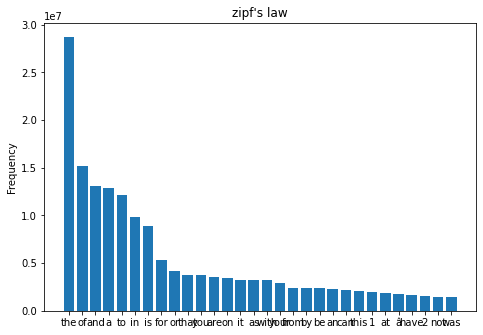

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# TODO
term_list = [ ]
freq_list = [ ]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i, term in enumerate(index_reader.terms()):
    term_list.append(term.term)
    freq_list.append(term.cf)
sorted_term = [x for i, x in sorted(zip(freq_list, term_list), reverse=True)]
sorted_freq = sorted(freq_list, reverse=True)
ax.bar(sorted_term[:30], sorted_freq[:30])
ax.set_ylabel('Frequency')
ax.set_title("zipf's law")
plt.show()

### Reflections: 
What do you notice about this plot? What is it telling you?

Next, modify the above script yet again so that it produces a plot that only shows terms that have a frequency above 50,000, and also plot the least 20 frequent terms. What is it telling you?

## Reindex the collection with Porter stemmer and stopwords removal

Using the code below, reindex the collection: this time we set `-stemmer` to `porter` and do not `-keepStopwords`.


In [7]:
!python -m pyserini.index -collection JsonCollection -generator DefaultLuceneDocumentGenerator \
 -threads 9 -input collection/collection_jsonl \
 -index indexes/lucene-index-msmarco-passage-PoterStemmerStopwords \
 -optimize \
 -storeRaw \
 -stemmer porter \
 -storePositions \
 -storeDocvectors

2021-08-30 12:43:56,981 INFO  [main] index.IndexCollection (IndexCollection.java:643) - Setting log level to INFO
2021-08-30 12:43:56,983 INFO  [main] index.IndexCollection (IndexCollection.java:646) - Starting indexer...
2021-08-30 12:43:56,983 INFO  [main] index.IndexCollection (IndexCollection.java:647) - ============ Loading Parameters ============
2021-08-30 12:43:56,984 INFO  [main] index.IndexCollection (IndexCollection.java:648) - DocumentCollection path: collection/collection_jsonl
2021-08-30 12:43:56,984 INFO  [main] index.IndexCollection (IndexCollection.java:649) - CollectionClass: JsonCollection
2021-08-30 12:43:56,984 INFO  [main] index.IndexCollection (IndexCollection.java:650) - Generator: DefaultLuceneDocumentGenerator
2021-08-30 12:43:56,985 INFO  [main] index.IndexCollection (IndexCollection.java:651) - Threads: 9
2021-08-30 12:43:56,985 INFO  [main] index.IndexCollection (IndexCollection.java:652) - Stemmer: porter
2021-08-30 12:43:56,986 INFO  [main] index.IndexCol

Redo the exercise 2 again with the new index, what is the difference?